## Using Average

In [1]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import trustworthiness
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
import random
import queue
import json
		

# Antenna definitions
ASSIGNMENTS = [
	[0, 13, 31, 29, 3, 7, 1, 12 ],
	[30, 26, 21, 25, 24, 8, 22, 15],
	[28, 5, 10, 14, 6, 2, 16, 18],
	[19, 4, 23, 17, 20, 11, 9, 27]
]

ANTENNACOUNT = np.sum([len(antennaArray) for antennaArray in ASSIGNMENTS])

def load_calibrate_timedomain(path, offset_path):
	offsets = None
	with open(offset_path, "r") as offsetfile:
		offsets = json.load(offsetfile)
	
	def record_parse_function(proto):
		record = tf.io.parse_single_example(
			proto,
			{
				"csi": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"time": tf.io.FixedLenFeature([], tf.float32, default_value=0),
			},
		)

		csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type=tf.float32), (ANTENNACOUNT, 1024, 2))
		csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
		csi = tf.signal.fftshift(csi, axes=1)

		position = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64), (3))
		time = tf.ensure_shape(record["time"], ())

		return csi, position[:2], time

	def apply_calibration(csi, pos, time):
		sto_offset = tf.tensordot(tf.constant(offsets["sto"]), 2 * np.pi * tf.range(tf.shape(csi)[1], dtype = np.float32) / tf.cast(tf.shape(csi)[1], np.float32), axes = 0)
		cpo_offset = tf.tensordot(tf.constant(offsets["cpo"]), tf.ones(tf.shape(csi)[1], dtype = np.float32), axes = 0)
		csi = tf.multiply(csi, tf.exp(tf.complex(0.0, sto_offset + cpo_offset)))

		return csi, pos, time

	def csi_time_domain(csi, pos, time):
		csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes=1)),axes=1)

		return csi, pos, time

	def cut_out_taps(tap_start, tap_stop):
		def cut_out_taps_func(csi, pos, time):
			return csi[:,tap_start:tap_stop], pos, time

		return cut_out_taps_func

	def order_by_antenna_assignments(csi, pos, time):
		csi = tf.stack([tf.gather(csi, antenna_inidces) for antenna_inidces in ASSIGNMENTS])
		return csi, pos, time
	
	dataset = tf.data.TFRecordDataset(path)
	
	dataset = dataset.map(record_parse_function, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(apply_calibration, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(cut_out_taps(507, 520), num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(order_by_antenna_assignments, num_parallel_calls = tf.data.AUTOTUNE)

	return dataset

inputpaths = [
	{
		"tfrecords" : "dichasus/dichasus-cf02.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf02.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf03.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf03.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf04.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf04.json"
	}
]

full_dataset = load_calibrate_timedomain(inputpaths[0]["tfrecords"], inputpaths[0]["offsets"])

for path in inputpaths[1:]:
	full_dataset = full_dataset.concatenate(load_calibrate_timedomain(path["tfrecords"], path["offsets"]))
                                            
                                            
                                            
# Decimate dataset: Use only every 4th datapoint (to reduce number of points)
training_set = full_dataset.enumerate().filter(lambda idx, value : (idx % 4 == 0))
training_set = training_set.map(lambda idx, value : value)
                                            
groundtruth_positions = []
csi_time_domain = []
timestamps = []

for csi, pos, time in training_set.batch(1000):
	csi_time_domain.append(csi.numpy())
	groundtruth_positions.append(pos.numpy())
	timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

/Users/tanishkamisra/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-19 13:39:13.219095: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [3]:
csi_time_domain.shape

(20997, 4, 8, 13)

In [2]:
H_avg = np.mean(csi_time_domain, axis=0)
h_time = np.fft.ifft(H_avg, axis=1) 
h_time = h_time.reshape(32, 13)
h_time.shape

(32, 13)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

W = 1024  # Number of subcarriers
modulation_order = 16  # 16-QAM
C = W // 8  # Cyclic prefix length
L = 13  # Length of channel impulse response (number of taps)
noise_power = 0 # Noise power
B = 32  # Number of receive antennas

## Transmitter
data = np.random.randint(0, modulation_order, W)  # Random QAM symbols
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)  # 16-QAM Mapping
qam_symbols /= np.sqrt(10)  # Normalize 

time_domain_signal = np.fft.ifft(qam_symbols)  # IDFT

cyclic_prefix = time_domain_signal[-C:] 

transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])  # +CP

## Wireless Channel

B = 32  # Number of receive antennas
np.random.seed(42)
h_bar_all = h_time
y_bar_all = []

# y_bar = h_bar (convolution) transmitted_signal
for b in range(B):
    h_bar = h_bar_all[b]  
    y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]  # Truncate to match length
    n_bar = noise_power * (np.random.randn(W + C) + 1j * np.random.randn(W + C))  # noise
    y_bar_all.append(y_bar + n_bar)

## Receiver

H_hat = np.zeros((B, W), dtype=complex)  #CSI matrix (B antennas x W subcarriers)

for b in range(B):
    y_no_cp = y_bar_all[b][C:] # -CP
    
    y_freq = np.fft.fft(y_no_cp) #DFT
    
    h_bar_padded = np.zeros(W, dtype=complex) # Zero-padding h_bar + DFT
    h_bar_padded[:L] = h_bar_all[b]
    h_freq = np.fft.fft(h_bar_padded)
    
    H_hat[b, :] = h_freq

s_received_all = np.zeros((B, W), dtype=complex)

# Equalization for each antenna
for b in range(B):
    y_no_cp = y_bar_all[b][C:]  # -CP
    y_freq = np.fft.fft(y_no_cp)  # DFT
    s_received_all[b, :] = y_freq / (H_hat[b, :] + 1e-8)  # Equalization

# Combining signals from all antennas by averaging
s_received = np.mean(s_received_all, axis=0)


# Quantization: Map received symbols back to the QAM constellation
real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

def quantize_to_qam(received_symbols, constellation):
    distances = np.abs(received_symbols[:, None] - constellation[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    return constellation[nearest_indices]

received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

# Compute BER
bit_errors = np.sum(received_symbols_quantized != qam_symbols)
total_bits = W * np.log2(modulation_order)  # Total bits transmitted
ber = bit_errors / total_bits

print("\nBit Error Rate (BER):", ber)


Bit Error Rate (BER): 0.0


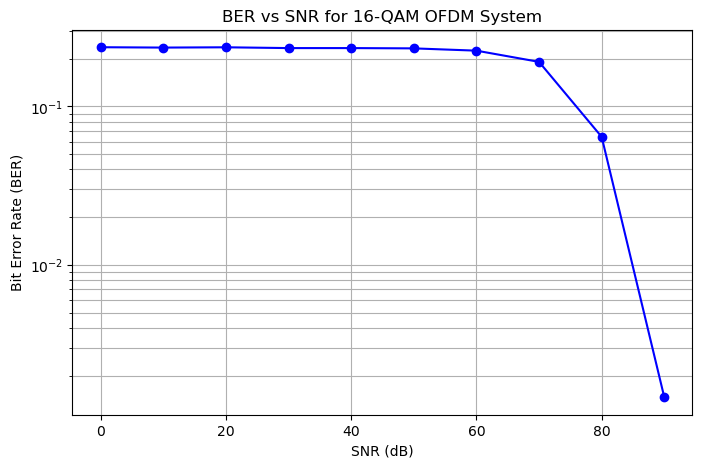

In [17]:
import numpy as np
import matplotlib.pyplot as plt

W = 1024  # Number of subcarriers
modulation_order = 16  # 16-QAM
C = W // 8  # Cyclic prefix length
L = 13  # Length of channel impulse response (number of taps)
B = 32  # Number of receive antennas

## Transmitter
data = np.random.randint(0, modulation_order, W)  # Random QAM symbols
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)  # 16-QAM Mapping
qam_symbols /= np.sqrt(10)  # Normalize 

time_domain_signal = np.fft.ifft(qam_symbols)  # IDFT
cyclic_prefix = time_domain_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])  # +CP

## Wireless Channel
np.random.seed(42)
h_bar_all = h_time

# SNR range (in dB)
snr_db_range = np.arange(0, 100, 10)  # From 0 dB to 24 dB in steps of 2
error_rates = []

for snr_db in snr_db_range:
    noise_power = 10 ** (-snr_db / 10)  # Convert SNR from dB to linear scale
    y_bar_all = []
    
    for b in range(B):
        h_bar = h_bar_all[b]  
        y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]  # Truncate to match length
        n_bar = np.sqrt(noise_power) * (np.random.randn(W + C) + 1j * np.random.randn(W + C))  # noise
        y_bar_all.append(y_bar + n_bar)

    ## Receiver
    H_hat = np.zeros((B, W), dtype=complex)  # CSI matrix (B antennas x W subcarriers)

    for b in range(B):
        y_no_cp = y_bar_all[b][C:] # -CP
        y_freq = np.fft.fft(y_no_cp) #DFT
        
        h_bar_padded = np.zeros(W, dtype=complex) # Zero-padding h_bar + DFT
        h_bar_padded[:L] = h_bar_all[b]
        h_freq = np.fft.fft(h_bar_padded)
        
        H_hat[b, :] = h_freq

    s_received_all = np.zeros((B, W), dtype=complex)

    # Equalization for each antenna
    for b in range(B):
        y_no_cp = y_bar_all[b][C:]  # -CP
        y_freq = np.fft.fft(y_no_cp)  # DFT
        s_received_all[b, :] = y_freq / (H_hat[b, :] + 1e-8)  # Equalization

    # Combining signals from all antennas by averaging
    s_received = np.mean(s_received_all, axis=0)

    # Quantization: Map received symbols back to the QAM constellation
    real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

    def quantize_to_qam(received_symbols, constellation):
        distances = np.abs(received_symbols[:, None] - constellation[None, :])
        nearest_indices = np.argmin(distances, axis=1)
        return constellation[nearest_indices]

    received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

    # Compute BER
    bit_errors = np.sum(received_symbols_quantized != qam_symbols)
    total_bits = W * np.log2(modulation_order)  # Total bits transmitted
    ber = bit_errors / total_bits
    error_rates.append(ber)

# Plot BER vs SNR

plt.figure(figsize=(8, 5))
plt.semilogy(snr_db_range, error_rates, marker='o', linestyle='-', color='b')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs SNR for 16-QAM OFDM System")
plt.grid(True, which='both')
plt.show()

In [44]:

import matplotlib.pyplot as plt

W = 1024  
modulation_order = 16  
C = W // 8  
L = 113  
Lp = 16  
noise_power = 0.1
B = 32  

data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  
time_domain_signal = np.fft.ifft(qam_symbols)

A_k = np.random.uniform(0, 1, Lp)  
phi_k = np.random.uniform(0, 2 * np.pi, Lp)  
p_bar = A_k * np.exp(1j * phi_k)  
p_bar /= np.linalg.norm(p_bar)  

perturbed_signal = np.convolve(p_bar, time_domain_signal, mode="full")[:W]

cyclic_prefix = perturbed_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, perturbed_signal])

np.random.seed(42)
h_bar_all = [np.random.randn(L) + 1j * np.random.randn(L) for _ in range(B)]
y_bar_all = []

for b in range(B):
    h_bar = h_bar_all[b]
    y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
    n_bar = noise_power * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
    y_bar_all.append(y_bar + n_bar)

H_hat = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]
    y_freq = np.fft.fft(y_no_cp)
    h_bar_padded = np.zeros(W, dtype=complex)
    h_bar_padded[:L] = h_bar_all[b]
    h_freq = np.fft.fft(h_bar_padded)
    H_hat[b, :] = h_freq

s_received_all = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]
    y_freq = np.fft.fft(y_no_cp)
    s_received_all[b, :] = y_freq / H_hat[b, :]

s_received = np.mean(s_received_all, axis=0)

difference = qam_symbols - s_received

real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

def quantize_to_qam(received_symbols, constellation):
    distances = np.abs(received_symbols[:, None] - constellation[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    return constellation[nearest_indices]

received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

bit_errors = np.sum(received_symbols_quantized != qam_symbols)
total_bits = W * np.log2(modulation_order)
ber = bit_errors / total_bits

print("\nBit Error Rate (BER):", ber)



Bit Error Rate (BER): 0.224853515625


## Using MMSE

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
noise_power = 0  # Set some noise power
B = 32  # Number of antennas

# Generate random QAM symbols
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Perform IFFT and add Cyclic Prefix (CP)
time_domain_signal = np.fft.ifft(qam_symbols)
cyclic_prefix = time_domain_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])

# Generate B independent channel impulse responses
np.random.seed(42)
h_bar_all = h_time
y_bar_all = []

# Pass the signal through each channel and add noise
for b in range(B):
    h_bar = h_bar_all[b]
    y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
    n_bar = noise_power * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
    y_bar_all.append(y_bar + n_bar)

# Channel estimation: Convert impulse responses to frequency domain
H_hat = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]  # Remove CP
    y_freq = np.fft.fft(y_no_cp)  # FFT to get frequency domain signal
    h_bar_padded = np.zeros(W, dtype=complex)
    h_bar_padded[:L] = h_bar_all[b]
    h_freq = np.fft.fft(h_bar_padded)  # Channel in frequency domain
    H_hat[b, :] = h_freq  # Store estimated channel response

# Frequency domain received signal
s_received_all = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]  # Remove CP
    y_freq = np.fft.fft(y_no_cp)  # FFT of received signal
    s_received_all[b, :] = y_freq  # Store received frequency domain signal

# MMSE Equalization
s_received = np.zeros(W, dtype=complex)

for w in range(W):
    h_w = H_hat[:, w].reshape(-1, 1)  # Channel for each subcarrier (B x 1)
    y_w = s_received_all[:, w]  # Received signal across B antennas

    # Compute MMSE filter
    mmse_filter = np.linalg.inv(h_w.conj().T @ h_w + noise_power * np.eye(1)) @ h_w.conj().T

    # Apply MMSE equalization
    s_received[w] = np.dot(mmse_filter, y_w)[0]  # Extract scalar value

# Calculate difference between original and recovered symbols
difference = qam_symbols - s_received

# Define QAM constellation points
real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

# Function to quantize received symbols to the nearest QAM constellation point
def quantize_to_qam(received_symbols, constellation):
    distances = np.abs(received_symbols[:, None] - constellation[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    return constellation[nearest_indices]

# Quantize received symbols to nearest QAM constellation point
received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

# Compute Bit Error Rate (BER)
bit_errors = np.sum(received_symbols_quantized != qam_symbols)
total_bits = W * np.log2(modulation_order)
ber = bit_errors / total_bits

print("Bit Error Rate (MMSE):", ber)


Bit Error Rate (MMSE): 0.0


SNR: -5 dB, Bit Error Rate (MMSE): 0.237548828125
SNR: 5 dB, Bit Error Rate (MMSE): 0.234130859375
SNR: 15 dB, Bit Error Rate (MMSE): 0.234130859375
SNR: 25 dB, Bit Error Rate (MMSE): 0.229248046875
SNR: 35 dB, Bit Error Rate (MMSE): 0.232666015625
SNR: 45 dB, Bit Error Rate (MMSE): 0.2255859375
SNR: 55 dB, Bit Error Rate (MMSE): 0.208251953125
SNR: 65 dB, Bit Error Rate (MMSE): 0.152099609375
SNR: 75 dB, Bit Error Rate (MMSE): 0.023193359375
SNR: 85 dB, Bit Error Rate (MMSE): 0.000244140625
SNR: 95 dB, Bit Error Rate (MMSE): 0.0


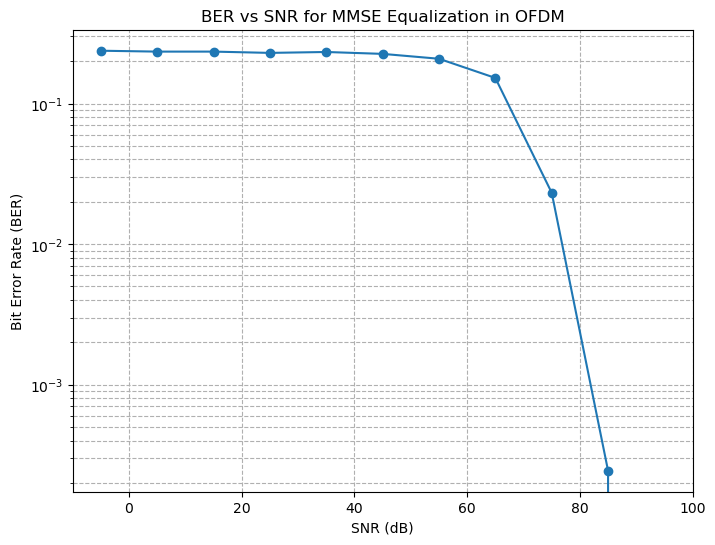

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
B = 32  # Number of antennas
snr_db_range = np.arange(-5, 100, 10)  # SNR range from -5 dB to 30 dB in steps of 2
ber_values = []  # Store BER for each SNR

# Generate random QAM symbols
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Perform IFFT and add Cyclic Prefix (CP)
time_domain_signal = np.fft.ifft(qam_symbols)
cyclic_prefix = time_domain_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])

# Generate B independent channel impulse responses
np.random.seed(42)
h_bar_all = h_time

for snr_db in snr_db_range:
    snr_linear = 10**(snr_db / 10)  # Convert dB to linear scale
    noise_power = 1 / snr_linear  # Noise power based on SNR

    y_bar_all = []
    for b in range(B):
        h_bar = h_bar_all[b]
        y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
        n_bar = np.sqrt(noise_power) * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
        y_bar_all.append(y_bar + n_bar)

    # Channel estimation: Convert impulse responses to frequency domain
    H_hat = np.zeros((B, W), dtype=complex)

    for b in range(B):
        y_no_cp = y_bar_all[b][C:]  # Remove CP
        y_freq = np.fft.fft(y_no_cp)  # FFT to get frequency domain signal
        h_bar_padded = np.zeros(W, dtype=complex)
        h_bar_padded[:L] = h_bar_all[b]
        h_freq = np.fft.fft(h_bar_padded)  # Channel in frequency domain
        H_hat[b, :] = h_freq  # Store estimated channel response

    # Frequency domain received signal
    s_received_all = np.zeros((B, W), dtype=complex)

    for b in range(B):
        y_no_cp = y_bar_all[b][C:]  # Remove CP
        y_freq = np.fft.fft(y_no_cp)  # FFT of received signal
        s_received_all[b, :] = y_freq  # Store received frequency domain signal

    # MMSE Equalization
    s_received = np.zeros(W, dtype=complex)

    for w in range(W):
        h_w = H_hat[:, w].reshape(-1, 1)  # Channel for each subcarrier (B x 1)
        y_w = s_received_all[:, w]  # Received signal across B antennas

        # Compute MMSE filter
        mmse_filter = np.linalg.inv(h_w.conj().T @ h_w + noise_power * np.eye(1)) @ h_w.conj().T

        # Apply MMSE equalization
        s_received[w] = np.dot(mmse_filter, y_w)[0]  # Extract scalar value

    # Define QAM constellation points
    real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

    # Function to quantize received symbols to the nearest QAM constellation point
    def quantize_to_qam(received_symbols, constellation):
        distances = np.abs(received_symbols[:, None] - constellation[None, :])
        nearest_indices = np.argmin(distances, axis=1)
        return constellation[nearest_indices]

    # Quantize received symbols to nearest QAM constellation point
    received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

    # Compute Bit Error Rate (BER)
    bit_errors = np.sum(received_symbols_quantized != qam_symbols)
    total_bits = W * np.log2(modulation_order)
    ber = bit_errors / total_bits
    ber_values.append(ber)

    print(f"SNR: {snr_db} dB, Bit Error Rate (MMSE): {ber}")

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_db_range, ber_values, marker='o', linestyle='-')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs SNR for MMSE Equalization in OFDM")
plt.grid(True, which='both', linestyle='--')
plt.show()


In [45]:
import numpy as np
import matplotlib.pyplot as plt

W = 1024  
modulation_order = 16  
C = W // 8  
L = 113 
Lp = 16  # Perturbation length
noise_power = 0
B = 32  

# Transmitter
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  
time_domain_signal = np.fft.ifft(qam_symbols)

# Perturbation 
A_k = np.random.uniform(0, 1, Lp)  
phi_k = np.random.uniform(0, 2 * np.pi, Lp)  # Phase
p_bar = A_k * np.exp(1j * phi_k)  
p_bar /= np.linalg.norm(p_bar)  # Normalize perturbation ||p_bar|| = 1

perturbed_signal = np.convolve(p_bar, time_domain_signal, mode="full")[:W]

cyclic_prefix = perturbed_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, perturbed_signal])

np.random.seed(42)
h_bar_all = [np.random.randn(L) + 1j * np.random.randn(L) for _ in range(B)]
y_bar_all = []

for b in range(B):
    h_bar = h_bar_all[b]
    y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
    n_bar = noise_power * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
    y_bar_all.append(y_bar + n_bar)

# Receiver
H_hat = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]
    y_freq = np.fft.fft(y_no_cp)
    h_bar_padded = np.zeros(W, dtype=complex)
    h_bar_padded[:L] = h_bar_all[b]
    h_freq = np.fft.fft(h_bar_padded)
    H_hat[b, :] = h_freq

# MMSE Equalization
s_received_all = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]
    y_freq = np.fft.fft(y_no_cp)
    s_received_all[b, :] = y_freq  

s_received = np.zeros(W, dtype=complex)

for w in range(W):
    h_w = H_hat[:, w].reshape(-1, 1)  # Channel vector for each subcarrier (B x 1)
    y_w = s_received_all[:, w]  # Received signal across B antennas

    # Compute MMSE filter
    mmse_filter = np.linalg.inv(h_w.conj().T @ h_w + noise_power * np.eye(1)) @ h_w.conj().T

    # Apply MMSE equalization
    s_received[w] = np.dot(mmse_filter, y_w)[0]  # Extract scalar value

# Compute the difference between transmitted and received symbols
difference = qam_symbols - s_received

# Compute Bit Error Rate (BER)
real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

def quantize_to_qam(received_symbols, constellation):
    distances = np.abs(received_symbols[:, None] - constellation[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    return constellation[nearest_indices]

received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

bit_errors = np.sum(received_symbols_quantized != qam_symbols)
total_bits = W * np.log2(modulation_order)
ber = bit_errors / total_bits

print("\nBit Error Rate (BER) with MMSE Equalization:", ber)



Bit Error Rate (BER) with MMSE Equalization: 0.226806640625


## Using ZF Forcing

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
noise_power = 0 # Set some noise power
B = 32  # Number of antennas

# Generate random QAM symbols
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Perform IFFT and add Cyclic Prefix (CP)
time_domain_signal = np.fft.ifft(qam_symbols)
cyclic_prefix = time_domain_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])

# Generate B independent channel impulse responses
np.random.seed(42)
h_bar_all = h_time
y_bar_all = []

# Pass the signal through each channel and add noise
for b in range(B):
    h_bar = h_bar_all[b]
    y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
    n_bar = noise_power * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
    y_bar_all.append(y_bar + n_bar)

# Channel estimation: Convert impulse responses to frequency domain
H_hat = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]  # Remove CP
    y_freq = np.fft.fft(y_no_cp)  # FFT to get frequency domain signal
    h_bar_padded = np.zeros(W, dtype=complex)
    h_bar_padded[:L] = h_bar_all[b]
    h_freq = np.fft.fft(h_bar_padded)  # Channel in frequency domain
    H_hat[b, :] = h_freq  # Store estimated channel response

# Frequency domain received signal
s_received_all = np.zeros((B, W), dtype=complex)

for b in range(B):
    y_no_cp = y_bar_all[b][C:]  # Remove CP
    y_freq = np.fft.fft(y_no_cp)  # FFT of received signal
    s_received_all[b, :] = y_freq  # Store received frequency domain signal

# ZF Equalization
s_received_zf = np.zeros(W, dtype=complex)

for w in range(W):
    h_w = H_hat[:, w].reshape(-1, 1)  # Channel for each subcarrier (B x 1)
    y_w = s_received_all[:, w]  # Received signal across B antennas

    # Compute ZF filter
    zf_filter = np.linalg.pinv(h_w)  # Pseudo-inverse of channel matrix

    # Apply ZF equalization
    s_received_zf[w] = np.dot(zf_filter, y_w)[0]  # Extract scalar value

# Define QAM constellation points
real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

# Function to quantize received symbols to the nearest QAM constellation point
def quantize_to_qam(received_symbols, constellation):
    distances = np.abs(received_symbols[:, None] - constellation[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    return constellation[nearest_indices]

# Quantize received symbols to nearest QAM constellation point
received_symbols_quantized_zf = quantize_to_qam(s_received_zf, qam_constellation)

# Compute Bit Error Rate (BER)
total_bits = W * np.log2(modulation_order)
bit_errors_zf = np.sum(received_symbols_quantized_zf != qam_symbols)
ber_zf = bit_errors_zf / total_bits

print("Bit Error Rate (ZF):", ber_zf)

Bit Error Rate (ZF): 0.0


SNR: -5 dB, Bit Error Rate (ZF): 0.234619140625
SNR: 5 dB, Bit Error Rate (ZF): 0.237548828125
SNR: 15 dB, Bit Error Rate (ZF): 0.231689453125
SNR: 25 dB, Bit Error Rate (ZF): 0.23583984375
SNR: 35 dB, Bit Error Rate (ZF): 0.236083984375
SNR: 45 dB, Bit Error Rate (ZF): 0.23193359375
SNR: 55 dB, Bit Error Rate (ZF): 0.21142578125
SNR: 65 dB, Bit Error Rate (ZF): 0.15478515625
SNR: 75 dB, Bit Error Rate (ZF): 0.02294921875
SNR: 85 dB, Bit Error Rate (ZF): 0.000244140625
SNR: 95 dB, Bit Error Rate (ZF): 0.0


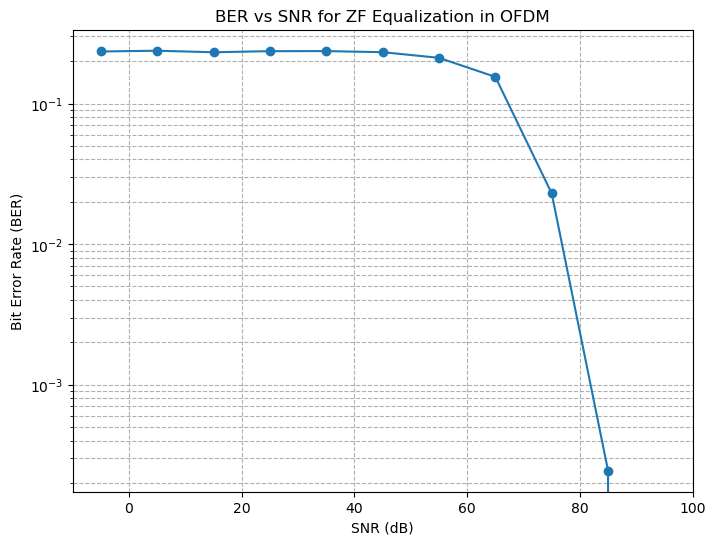

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
B = 32  # Number of antennas
snr_db_range = np.arange(-5, 100, 10)  # SNR range from -5 dB to 100 dB in steps of 10
ber_values = []  # Store BER for each SNR

# Generate random QAM symbols
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Perform IFFT and add Cyclic Prefix (CP)
time_domain_signal = np.fft.ifft(qam_symbols)
cyclic_prefix = time_domain_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, time_domain_signal])

# Generate B independent channel impulse responses
np.random.seed(42)
h_bar_all = h_time

for snr_db in snr_db_range:
    snr_linear = 10**(snr_db / 10)  # Convert dB to linear scale
    noise_power = 1 / snr_linear  # Noise power based on SNR

    y_bar_all = []
    for b in range(B):
        h_bar = h_bar_all[b]
        y_bar = np.convolve(h_bar, transmit_signal, mode='full')[:W + C]
        n_bar = np.sqrt(noise_power) * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
        y_bar_all.append(y_bar + n_bar)

    # Channel estimation: Convert impulse responses to frequency domain
    H_hat = np.zeros((B, W), dtype=complex)

    for b in range(B):
        y_no_cp = y_bar_all[b][C:]  # Remove CP
        y_freq = np.fft.fft(y_no_cp)  # FFT to get frequency domain signal
        h_bar_padded = np.zeros(W, dtype=complex)
        h_bar_padded[:L] = h_bar_all[b]
        h_freq = np.fft.fft(h_bar_padded)  # Channel in frequency domain
        H_hat[b, :] = h_freq  # Store estimated channel response

    # Frequency domain received signal
    s_received_all = np.zeros((B, W), dtype=complex)

    for b in range(B):
        y_no_cp = y_bar_all[b][C:]  # Remove CP
        y_freq = np.fft.fft(y_no_cp)  # FFT of received signal
        s_received_all[b, :] = y_freq  # Store received frequency domain signal

    # ZF Equalization
    s_received = np.zeros(W, dtype=complex)

    for w in range(W):
        h_w = H_hat[:, w].reshape(-1, 1)  # Channel for each subcarrier (B x 1)
        y_w = s_received_all[:, w]  # Received signal across B antennas

        # Compute ZF filter
        zf_filter = np.linalg.pinv(h_w)  # Pseudo-inverse of channel matrix

        # Apply ZF equalization
        s_received[w] = np.dot(zf_filter, y_w)[0]  # Extract scalar value

    # Define QAM constellation points
    real_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    imag_parts = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    qam_constellation = np.array([x + 1j * y for x in real_parts for y in imag_parts])

    # Function to quantize received symbols to the nearest QAM constellation point
    def quantize_to_qam(received_symbols, constellation):
        distances = np.abs(received_symbols[:, None] - constellation[None, :])
        nearest_indices = np.argmin(distances, axis=1)
        return constellation[nearest_indices]

    # Quantize received symbols to nearest QAM constellation point
    received_symbols_quantized = quantize_to_qam(s_received, qam_constellation)

    # Compute Bit Error Rate (BER)
    bit_errors = np.sum(received_symbols_quantized != qam_symbols)
    total_bits = W * np.log2(modulation_order)
    ber = bit_errors / total_bits
    ber_values.append(ber)

    print(f"SNR: {snr_db} dB, Bit Error Rate (ZF): {ber}")

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_db_range, ber_values, marker='o', linestyle='-')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs SNR for ZF Equalization in OFDM")
plt.grid(True, which='both', linestyle='--')
plt.show()
